# Ask Bedrock about Bedrock: _Bedrockception_ RAG

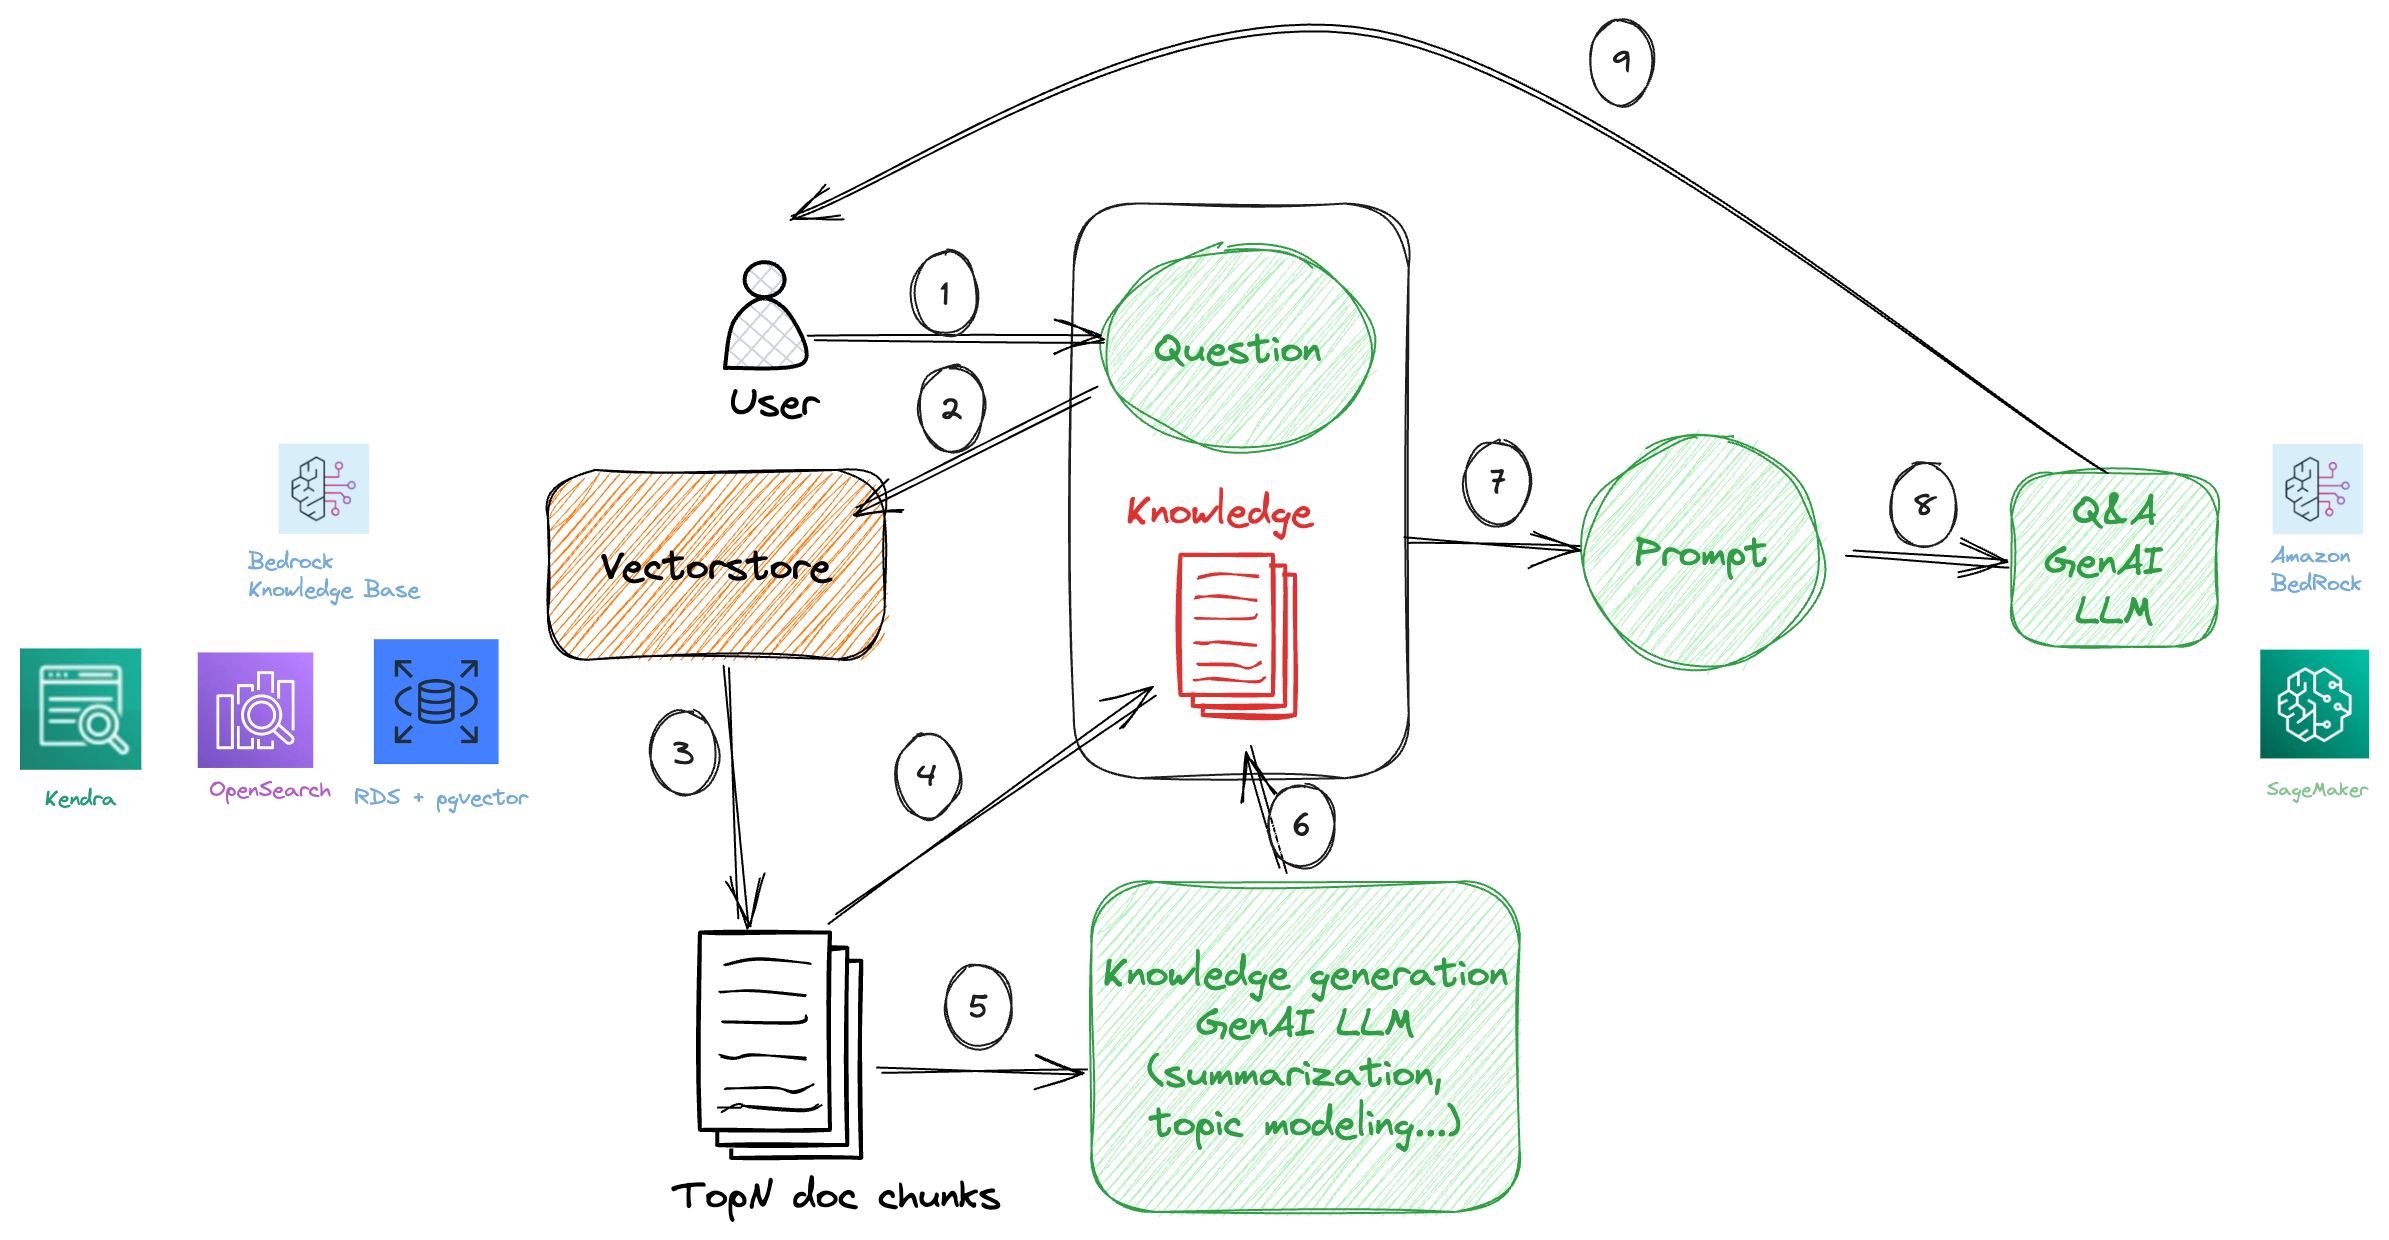

## Objective 

This notebook aims at exploring various RAG options with Amazon Bedrock: 
* we'll first leverage langchain alongside ChromaDB, a local vector store.
* then, we'll pursue with Hypothetical Document Embedding technique 
* we'll conclude with a scalable way to do so with Bedrock Knowledge Base

## Setup

### Libraries

In [82]:
%pip install --quiet \
    langchain==0.0.309 \
    "transformers>=4.24,<5" \
    sqlalchemy -U \
    "faiss-cpu>=1.7,<2" \
    "pypdf>=3.8,<4" \
    pinecone-client \
    apache-beam \
    datasets \
    tiktoken \
    "ipywidgets>=7,<8" \
    matplotlib \
    boto3 \
    chromadb==0.4.15 \
    langchainhub


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Objective of this notebook is to provide a simple example for RAG, including Bedrock knowledge base.

### Creating a data repository for documentation

We are going to create a repository containing the data needed for our RAG application.

In [3]:
!mkdir -p data/

In [4]:
!wget https://docs.aws.amazon.com/pdfs/bedrock/latest/userguide/bedrock-ug.pdf --directory-prefix=./data

--2024-01-29 08:04:34--  https://docs.aws.amazon.com/pdfs/bedrock/latest/userguide/bedrock-ug.pdf
Resolving docs.aws.amazon.com (docs.aws.amazon.com)... 99.84.108.49, 99.84.108.99, 99.84.108.120, ...
Connecting to docs.aws.amazon.com (docs.aws.amazon.com)|99.84.108.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4703721 (4.5M) [application/pdf]
Saving to: ‘./data/bedrock-ug.pdf.1’

bedrock-ug.pdf.1    100%[===================>]   4.49M  --.-KB/s    in 0.06s   

2024-01-29 08:04:34 (75.8 MB/s) - ‘./data/bedrock-ug.pdf.1’ saved [4703721/4703721]



In [5]:
!wget https://docs.aws.amazon.com/pdfs/bedrock/latest/APIReference/bedrock-api.pdf --directory-prefix=./data

--2024-01-29 08:04:35--  https://docs.aws.amazon.com/pdfs/bedrock/latest/APIReference/bedrock-api.pdf
Resolving docs.aws.amazon.com (docs.aws.amazon.com)... 99.84.108.81, 99.84.108.120, 99.84.108.99, ...
Connecting to docs.aws.amazon.com (docs.aws.amazon.com)|99.84.108.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3780987 (3.6M) [application/pdf]
Saving to: ‘./data/bedrock-api.pdf.1’

bedrock-api.pdf.1   100%[===================>]   3.61M  8.18MB/s    in 0.4s    

2024-01-29 08:04:36 (8.18 MB/s) - ‘./data/bedrock-api.pdf.1’ saved [3780987/3780987]



## The simple case: ChromaDB

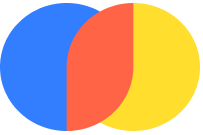

[ChromaDB](https://www.trychroma.com/) is a native in-memory vector database solution. It is a very friendly entrypoint to embedding solutions. All it takes it a `pip install chromadb` (plus some dependencies if you're lucky, 🐍 style). We are going to create a collection of embeddings, executing the following steps.

We begin with instantiating the LLM and the Embeddings model. Here we are using Anthropic Claude for text generation and Amazon Titan for text embedding.

Note: It is possible to choose other models available with Bedrock. You can replace the `model_id` as follows to change the model.

`llm = Bedrock(model_id="amazon.titan-text-express-v1")`

Check [documentation](https://docs.aws.amazon.com/bedrock/latest/userguide/model-ids-arns.html) for Available text generation and embedding models Ids under Amazon Bedrock.

### Load documents into langchain format

In [2]:
# We will be using the Titan Embeddings Model to generate our Embeddings.
from langchain.embeddings import BedrockEmbeddings
from langchain.llms.bedrock import Bedrock
import boto3



In [3]:
from langchain.document_loaders import PyPDFLoader
loader = PyPDFLoader("./data/bedrock-api.pdf")
api_pages = loader.load_and_split()

loader = PyPDFLoader("./data/bedrock-ug.pdf")
ug_pages = loader.load_and_split()

### Create a local vector store

In [28]:
import json
bedrockruntime = boto3.client('bedrock-runtime')
bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1", client=bedrockruntime)

In [29]:

from langchain.vectorstores import chroma
bigvectorstore_chroma = chroma.Chroma.from_documents(
    api_pages+ug_pages,
    bedrock_embeddings
)

In [51]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

prompt_template = """

Human: Use the following pieces of context to provide an accurate answer to the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

<context>
{context}
</context

Question: {question}

Assistant:"""


# - create the Anthropic Model
llm = Bedrock(model_id="anthropic.claude-v2", client=bedrockruntime, model_kwargs={'max_tokens_to_sample':1024})
PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=bigvectorstore_chroma.as_retriever(
        search_type="similarity", search_kwargs={"k": 5}
    ),
    return_source_documents=False,
    chain_type_kwargs={"prompt": PROMPT},
    verbose = True
)


In [60]:
query = """How to invoke a bedrock model with boto3? Provide a concrete example"""
result = qa({"query": query})





> Entering new RetrievalQA chain...

> Finished chain.


In [61]:
from IPython.display import Markdown, display

display(Markdown(result['result']))

 Here is a code snippet to invoke a Bedrock model using boto3 in Python:

```python
import boto3

bedrock = boto3.client('bedrock-runtime')

response = bedrock.invoke_model(
    modelId='arn:aws:bedrock:us-west-2:123456789012:model/mymodel',
    body='{"inputText":"Hello World"}',
)

print(response['body'].read())
```

The key steps are:

- Create a Bedrock Runtime client 
- Call `invoke_model` method, passing the model ARN and input text 
- The response contains the model output in the `body`

This makes a synchronous invocation to run the model and returns the result.

In [58]:
query = """What are Bedrock Knowledge Bases?"""
response = qa({"query": query})



> Entering new RetrievalQA chain...

> Finished chain.


In [59]:
display(Markdown(response['result']))

 Based on the provided context, Amazon Bedrock Knowledge Bases are repositories of information that can be queried to augment responses from AI agents and applications. Key points about Bedrock Knowledge Bases:

- They allow you to ingest various data sources like documents, FAQs, manuals, etc. into a centralized repository.

- They support retrieval augmented generation (RAG), where retrieved knowledge is used to augment AI-generated responses.

- Knowledge bases can be queried via APIs to retrieve relevant information or to generate responses augmented with retrieved content.

- Knowledge bases can be associated with Bedrock agents to augment their capabilities. 

- Setting up a knowledge base involves configuring data sources, ingesting data, and then querying the knowledge base from an application or agent.

So in summary, Bedrock Knowledge Bases are databases of information that can be leveraged to enhance AI systems with relevant knowledge and context. Their key purpose is to improve the quality and factual correctness of AI-generated responses.

In [145]:
query = """Is user data safe when invoking Amazon Bedrock models?"""
response = qa({"query": query})



> Entering new RetrievalQA chain...

> Finished chain.


In [146]:
display(Markdown(response['result']))

 Based on the provided context, user data is encrypted when invoking Amazon Bedrock models. The context indicates that customer data is always encrypted both in transit and at rest for Amazon Bedrock model evaluation jobs. Intermediary customer data stored during model evaluation is encrypted at rest and deleted after the job completes. The context also mentions that input and output data for model customization jobs is encrypted by default using AWS managed keys, but users can choose to encrypt with their own customer managed keys as well. So in summary, yes, the context suggests that user data is encrypted and protected when invoking Amazon Bedrock models.

## HyDE

HyDE stands for HYpothetical Document Embeddings. Originally quoted in this [paper](https://arxiv.org/pdf/2212.10496.pdf). Its core idea is pretty simple: 
* The LLM is used to provide a hypothetical answer, even if it is a faulty one.
* The expectation is that the generative process capture "structure relevance", acting like a factual document.
* This "faulty" document will then be embedded and compared with the embedding corpus.

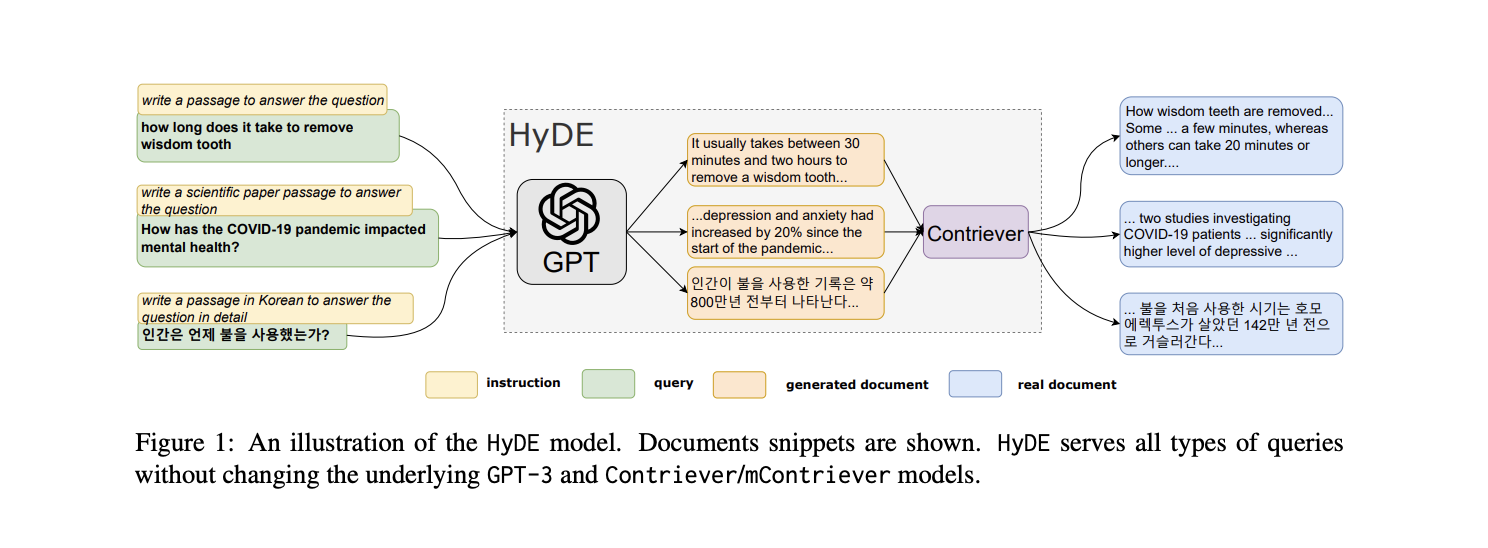

In [123]:
from langchain.chains import HypotheticalDocumentEmbedder, LLMChain
from langchain.prompts import PromptTemplate


In [124]:
llm = Bedrock(model_id="anthropic.claude-v2", client=bedrockruntime, model_kwargs={'max_tokens_to_sample':1024})
bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1", client=bedrockruntime)

In [125]:
hyde = HypotheticalDocumentEmbedder.from_llm(llm, bedrock_embeddings, "web_search")

In [129]:
prompt_template = """
Human:

Please answer the user's question about Amazon Bedrock
Question: {question}

Assistant:
"""


llm = Bedrock(model_id="anthropic.claude-v2", client=bedrockruntime, model_kwargs={'max_tokens_to_sample':1024})
prompt = PromptTemplate(input_variables=["question"], template=prompt_template)
llm_chain = LLMChain(llm=llm, prompt=prompt)

bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1", client=bedrockruntime)
hyde_embeddings = HypotheticalDocumentEmbedder(llm_chain=llm_chain, base_embeddings=bedrock_embeddings)

In [136]:
hydevectorstore_chroma = chroma.Chroma.from_documents(
    api_pages+ug_pages,
    hyde_embeddings
)

In [137]:
prompt_template = """

Human: Use the following pieces of context to provide an accurate answer to the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

<context>
{context}
</context

Question: {question}

Assistant:"""


# - create the Anthropic Model
llm = Bedrock(model_id="anthropic.claude-v2", client=bedrockruntime, model_kwargs={'max_tokens_to_sample':1024})
PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)


hyde_qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=hydevectorstore_chroma.as_retriever(
        search_type="similarity", search_kwargs={"k": 5}
    ),
    return_source_documents=False,
    chain_type_kwargs={"prompt": PROMPT},
    verbose = True
)


In [138]:
query = """How to invoke a bedrock model with boto3? Provide a concrete example"""
res = hyde_qa({"query": query})





> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/langchain/llms/bedrock.py:46: UserWarning: Error: Prompt must alternate between '

Human:' and '

Assistant:'. Received 

Human: Use the following pieces of context to provide an accurate answer to the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

<context>
Amazon Bedrock User Guide
{ 
    "Version": "2012-10-17", 
    "Statement": [ 
        { 
            "Effect": "Allow", 
            "Principal": { 
                "Service": "bedrock.amazonaws.com" 
            }, 
            "Action": "sts:AssumeRole" 
        }, 
        { 
            "Sid": "", 
            "Effect": "Allow", 
            "Principal": { 
                "Service": "sagemaker.amazonaws.com" 
            }, 
            "Action": "sts:AssumeRole" 
        } 
    ]
}                    
Test the Runtime setup
Add the following code to your notebook and run the code.
import boto3
import json
bedrock = boto


> Finished chain.


In [140]:
display(Markdown(res['result']))

 Based on the context provided, to invoke a Bedrock model with Boto3 in a SageMaker notebook, you would do something like:

```python
import boto3
import json

bedrock = boto3.client(service_name='bedrock')

body = json.dumps({
  "prompt": "Hello world",
  "max_tokens_to_sample": 100,
  "temperature": 0.7,
  "top_p": 0.9
})

model_id = 'model-id-here' 

response = bedrock.invoke_model(
    body=body,
    modelId=model_id
)

print(response['text'])
```

This creates a Bedrock client, prepares the request body with the prompt and sampling parameters, specifies the model ID to invoke, and then calls `invoke_model()` to get the model's response. The response text is printed out.

In [143]:
query = """Is user data safe when invoking Amazon Bedrock models?"""
res = hyde_qa({"query": query})



> Entering new RetrievalQA chain...

> Finished chain.


In [144]:
display(Markdown(res['result']))

 Based on the context provided, user data is safe when invoking Amazon Bedrock models. The key points are:

- Amazon Bedrock doesn't use customer prompts and continuations to train any AWS models or distribute them to third parties. 

- Customer training data for model customization is only used for that purpose and is not retained after the customization is complete.

- Custom models themselves are encrypted using AWS KMS keys. Customers can use their own KMS keys if desired.

- Metadata about custom models is stored encrypted. 

- In general, AWS recommends customers use security best practices like MFA, TLS encryption, CloudTrail logging, and encryption to help secure their data.

So in summary, the context indicates user data is handled safely by Amazon Bedrock.

## The scalable way: Bedrock Knowledge Base


### 1. Put your desired content into an S3 bucket


### 2. Create a Bedrock Knowledge Base

Doable within the AWS console, as shown below

<img src="imgs/BedrockKbConsole720p.gif" width="750" align="center">



### 3. Use Bedrock Agent Runtime in `boto3`

In [ ]:
import boto3
agentruntime_client = boto3.client('bedrock-agent-runtime')
question = "How to setup a VPC endpoint for Amazon Bedrock?"
kb_config = {"knowledgeBaseId":"YourKnowledgeBaseId", "modelArn":"arn:aws:bedrock:us-east-1::foundation-model/anthropic.claude-v2"}
res = agentruntime_client.retrieve_and_generate( input={'text': question},retrieveAndGenerateConfiguration={"type":"KNOWLEDGE_BASE", 'knowledgeBaseConfiguration':kb_config})

In [165]:
display(Markdown(res['output']['text']))

To setup a VPC endpoint for Amazon Bedrock, you need to create an interface endpoint using AWS PrivateLink. This establishes a private connection between your VPC and Amazon Bedrock without needing an internet gateway, NAT device, VPN connection, or AWS Direct Connect. When creating the interface endpoint, you specify the VPC subnets and security groups to use. Amazon Bedrock will create endpoint network interfaces in the enabled subnets to serve as entry points for traffic to Amazon Bedrock. You can create the interface endpoint using either the Amazon VPC console or AWS CLI. The endpoints are powered by AWS PrivateLink.

Moreover, for each reference, the `retrieve_and_generate` provides references that helped in building the answer, as well as S3 location